## Import libraries

In [1]:
#General
import numpy as np
import pandas as pd
#from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import random
import time

#Image loading and processing
import os
from matplotlib import image
#from skimage.transform import resize
import cv2

#Model development
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as VGG16_preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as RN50_preprocess_input
from tensorflow.keras.optimizers import SGD

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())

True


## Define functions

In [6]:
def generate_image_set(breed_list, clean='y', threshold = 0, pic_size = (400,400,3)):

#Set up list of dog pics:
    path = 'dog_pics/'
    clean_path = 'clean_dog_pics/'
    file_list = sorted(os.listdir('dog_pics/'))
    file_list = file_list[1:]
    clean_file_list = sorted(os.listdir('clean_dog_pics/'))
    clean_file_list = clean_file_list[1:]

#Load pictures and labels from a specified breed list
    print('Loading pictures...')
    
    labels=[]
    images=list()
    for file in clean_file_list:
        dog_breed=file[6:-7]
        pic_pc = int(file[:-4].split('_')[-1])
        if dog_breed in breed_list:
            if pic_pc >= threshold:
                if clean == 'y':
                    data = np.asarray(image.imread(clean_path+file))
                else:
                    load_filename = file[:-7]+'.jpg'
                    data = np.asarray(image.imread(path+load_filename))
                if data.shape!=pic_size:
                    data = cv2.resize(data, dsize=(pic_size[1], pic_size[0]), interpolation=cv2.INTER_CUBIC)
#                    data = resize(data,pic_size, anti_aliasing=True)

                images.append(data)
                labels.append(dog_breed)                
    print('Setting up numpy array')
    images = np.array(images)
    
    print('Number of loaded images: ',len(images))
    print('Number of labels: ', len(labels))

#Set up label dictionaries and convert labels from text to integers for modelling
    breed_dict = {}
    for i in range (0, len(breed_list)):
        breed_dict[breed_list[i]]=i
    print(breed_dict)
    inv_breed_dict = {}
    for i in range (0, len(breed_list)):
        inv_breed_dict[i]=breed_list[i]
    print(inv_breed_dict)
    int_labels = [breed_dict[breed] for breed in labels]


#Set up train test split
    print('Setting up train/test split')
    train_images, test_images, train_labels, test_labels =\
    train_test_split(images, int_labels, test_size = 0.2, 
                     random_state = 1, shuffle = True, stratify = int_labels)
    

#Pre-process pictures for modelling
    print('Pre-processing pictures')
    train_images, test_images = train_images / 255.0, test_images / 255.0

#Reminder of baseline (updated to reflect number of loaded images):
    baseline_scores=[]
    for label in list(set(test_labels)):
        number_of_images = test_labels.count(label)
        pc_of_images = number_of_images / len(test_labels)
        print(inv_breed_dict[label],'; number of images: ',
              number_of_images, '; % of images', pc_of_images)
        baseline_scores.append(pc_of_images)
    baseline = max(baseline_scores)
    print('Baseline: ', baseline)
    
    return train_images, test_images, train_labels, test_labels, inv_breed_dict, baseline

In [7]:
#Set up third model definition to include dropouts.
def def_model3(outshape, pic_size = (400,400,3)):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=pic_size))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(outshape, activation='softmax'))

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    es = EarlyStopping(monitor = 'val_acc', min_delta = 0.0001, restore_best_weights=True)
    return model, es

In [8]:
#Set up fourth model definition to include a further 2 layers.
def def_model4(outshape, pic_size = (400,400,3)):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=pic_size))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(outshape, activation='softmax'))

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    es = EarlyStopping(monitor = 'val_acc', min_delta = 0.0001, restore_best_weights=True)
    return model, es

In [9]:
#Define functions for reviewing results
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(inv_breed_dict[predicted_label],
                                100*np.max(predictions_array),
                                inv_breed_dict[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(len(predictions_array)))
    plt.yticks([])
    thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        thisplot[predicted_label].set_color('green')
        thisplot[true_label].set_color('green')
    if predicted_label != true_label:
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('pink')

In [10]:
def review_results(predictions, test_labels, test_images, sample_size = 10):
    
    for counter in range(sample_size):
        i = random.randint(0,len(test_labels)-1)
        print(i)
        print(inv_breed_dict)
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plot_image(i, predictions[i], test_labels, test_images)
        plt.subplot(1,2,2)
        plot_value_array(i, predictions[i],  test_labels)
        plt.show()

In [11]:
def summarize_diagnostics(history):
    fig, ax = plt.subplots(nrows=2)
    # plot loss
    ax[0].plot(history.history['loss'], color='blue', label='train')
    ax[0].plot(history.history['val_loss'], color='orange', label='test')
    ax[0].set_title('Loss')
    # plot accuracy
    ax[1].plot(history.history['acc'], color='blue', label='train')
    ax[1].plot(history.history['val_acc'], color='orange', label='test')
    ax[1].set_title('Acc')
    fig.tight_layout()
    plt.show(); 

In [12]:
def model_documentation_nn(model_summary,
                           model, breed_list, training_sample_size,
                           pic_resolution, pic_masked, pic_quality,
                           baseline_score, validation_score,
                           train_score, test_score,
                           time_taken, notes):
    num_dog_breeds = len(breed_list)
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    short_model_summary = "\n".join(stringlist)
    model_summary = model_summary.append({
        'model_type' : type(model),
        'model_parameters' : short_model_summary,
        'number_dog_breeds' : num_dog_breeds,
        'dog_breeds' : breed_list,
        'training_sample_size' : training_sample_size,
        'picture_resolution' : pic_resolution,
        'pictures_masked' : pic_masked,
        'picture_quality' : pic_quality,
        'baseline_score' : baseline_score,
        'validation_score' : validation_score,
        'train_score' : train_score,
        'test_score' : test_score,
        'time_taken' : time_taken,
        'notes' : notes},
        ignore_index = True)
#Display latest entry
    last_row = model_summary.shape[0]-1
    print(model_summary.iloc[last_row])
    return model_summary

## Set up 1st dataset and model summary dataframe
3 breeds: labrador, cocker spaniel and french bulldog

In [13]:
breed_list = ['labrador', 'cocker_spaniel', 'french_bulldog']
clean = 'y'
threshold = 30
pic_size = (400, 400, 3)
train_images, test_images, train_labels, test_labels, inv_breed_dict, baseline =\
generate_image_set(breed_list, clean, threshold, pic_size)

Loading pictures...
Setting up numpy array
Number of loaded images:  2589
Number of labels:  2589
{'labrador': 0, 'cocker_spaniel': 1, 'french_bulldog': 2}
{0: 'labrador', 1: 'cocker_spaniel', 2: 'french_bulldog'}
Setting up train/test split
Pre-processing pictures
labrador ; number of images:  210 ; % of images 0.40540540540540543
cocker_spaniel ; number of images:  193 ; % of images 0.37258687258687256
french_bulldog ; number of images:  115 ; % of images 0.222007722007722
Baseline:  0.40540540540540543


In [14]:
#Set up temporary model summary dataframe
master_model_summary = pd.read_pickle('model_summary.pkl')
temp_model_summary = pd.DataFrame(columns=master_model_summary.columns)

Introduce first transformation - horizontal flip and random rotations.

### Test image augmentation

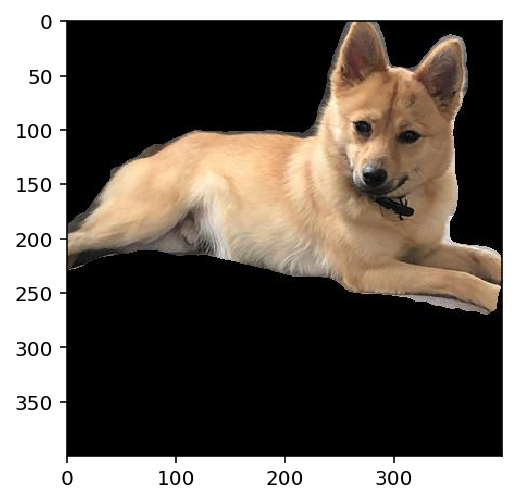

In [15]:
data = np.asarray(image.imread('clean_dog_pics/00003_pomchi_34.jpg'))
plt.imshow(data)

In [16]:
data = np.expand_dims(data, 0)
test_gen = ImageDataGenerator(horizontal_flip=True)
test_it = test_gen.flow(data, batch_size = 1)

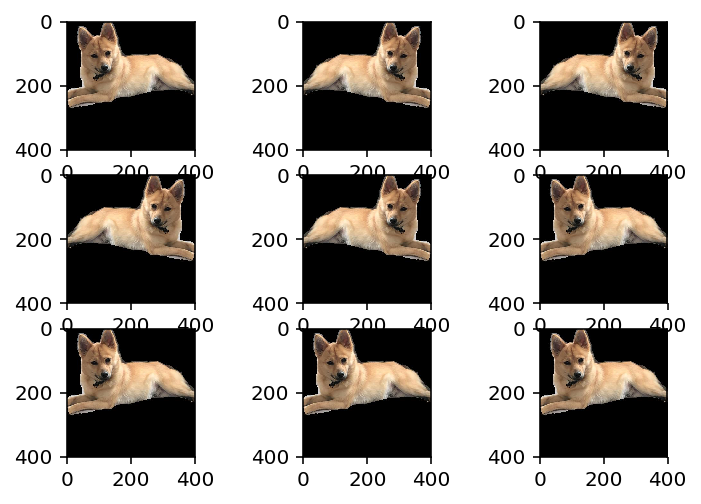

In [17]:
for i in range (9):
    plt.subplot(330+1+i)
    batch = test_it.next()
    pic = batch[0].astype('uint8')
    plt.imshow(pic)
plt.show()

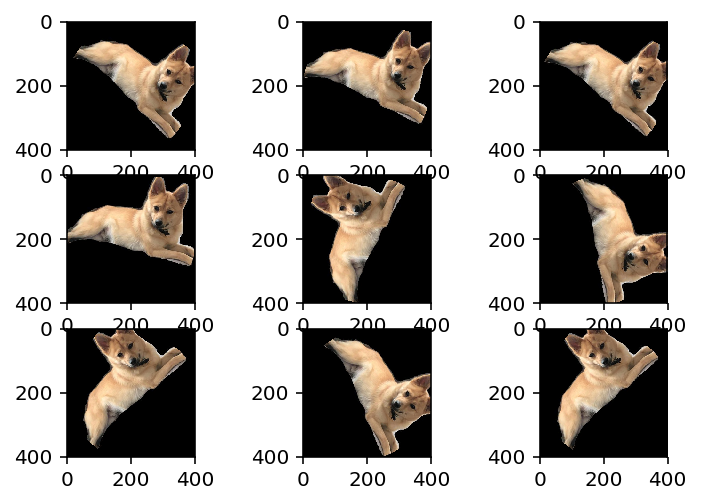

In [18]:
test_gen2 = ImageDataGenerator(rotation_range = 90, fill_mode='constant', cval = 0)
test_it2 = test_gen2.flow(data, batch_size = 1)
for i in range (9):
    plt.subplot(330+1+i)
    batch = test_it2.next()
    pic = batch[0].astype('uint8')
    plt.imshow(pic)
plt.show()

In [19]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range = 90,
                                   fill_mode='constant',
                                   cval = 0,
                                   validation_split=0.2)
train_generator = train_datagen.flow(train_images, train_labels, subset='training', batch_size = 32)
val_datagen = ImageDataGenerator(validation_split=0.2)
val_generator = val_datagen.flow(train_images, train_labels, subset='validation', batch_size = 32)

In [20]:
start_time = time.time()
model, es = def_model3(len(breed_list), pic_size)
es = EarlyStopping(monitor = 'val_acc', min_delta = 0.0001, 
                   patience=10, restore_best_weights=True)
history = model.fit_generator(train_generator, 
                    epochs=50, 
                    validation_data = val_generator,
                    validation_steps =  0.2 * len(train_images) / 32,
                    callbacks = [es])
print("Model accuracy")
best_model_index = history.history['val_acc'].index(max(history.history['val_acc']))
val_acc = history.history['val_acc'][best_model_index]
train_acc = history.history['acc'][best_model_index]
test_loss, test_acc = model.evaluate(test_images, test_labels)
model_time = time.time() - start_time

W0906 12:43:46.229995 140036667234048 deprecation.py:506] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/50
52/52 [==============================] - 47s 900ms/step - loss: 1.5582 - acc: 0.3603 - val_loss: 1.0756 - val_acc: 0.3841
Epoch 2/50
52/52 [==============================] - 49s 937ms/step - loss: 1.0846 - acc: 0.3923 - val_loss: 1.0716 - val_acc: 0.4130
Epoch 3/50
52/52 [==============================] - 49s 938ms/step - loss: 1.0787 - acc: 0.3917 - val_loss: 1.0653 - val_acc: 0.4082
Epoch 4/50
52/52 [==============================] - 49s 941ms/step - loss: 1.0687 - acc: 0.4007 - val_loss: 1.0514 - val_acc: 0.4130
Epoch 5/50
52/52 [==============================] - 49s 943ms/step - loss: 1.0671 - acc: 0.3971 - val_loss: 1.0303 - val_acc: 0.3986
Epoch 6/50
52/52 [==============================] - 49s 943ms/step - loss: 1.0489 - acc: 0.3983 - val_loss: 1.0189 - val_acc: 0.3961
Epoch 7/50
52/52 [==============================] - 49s 938ms/step - loss: 1.0438 - acc: 0.4110 - val_loss: 1.0144 - val_acc: 0.4493
Epoch 8/50
52/52 [==============================] - 49s 942ms/step - 

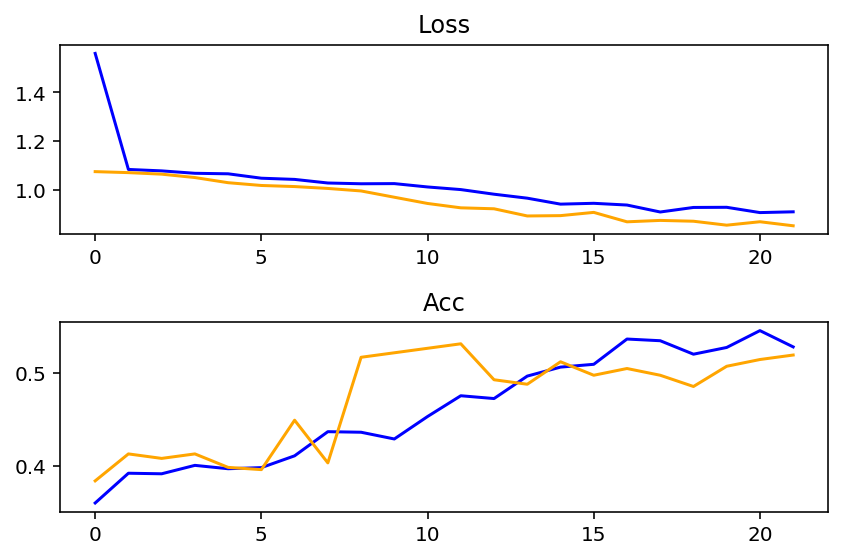

In [21]:
summarize_diagnostics(history)

In [22]:
notes = 'NN - model 3 + IA. Resolution of pictures test'
temp_model_summary = model_documentation_nn(temp_model_summary, model,
                                            breed_list, len(train_images), 
                                            train_images[0].shape,
                                            clean, threshold,
                                            baseline, val_acc,
                                            train_acc, test_acc,
                                            model_time, notes)

baseline_score                                                   0.405405
dog_breeds                     [labrador, cocker_spaniel, french_bulldog]
model                                                                 NaN
model_parameters        Model: "sequential"\n_________________________...
model_type              <class 'tensorflow.python.keras.engine.sequent...
notes                      NN - model 3 + IA. Resolution of pictures test
number_dog_breeds                                                       3
picture_quality                                                        30
picture_resolution                                          (400, 400, 3)
pictures_masked                                                         y
test_score                                                       0.513514
time_taken                                                        1079.48
train_score                                                      0.475558
training_sample_size                  

In [24]:
overall_history=[]
for i in [375, 350, 325, 300, 275, 250, 225, 200, 175, 150, 125, 100, 75, 50]:
    print('Resolution', i)
    pic_size = (i, i, 3)
    train_images, test_images, train_labels, test_labels, inv_breed_dict, baseline =\
    generate_image_set(breed_list, clean, threshold, pic_size)
    print('Total number of pictures: ', len(train_images))
    train_generator = train_datagen.flow(train_images, train_labels, 
                                         subset='training', batch_size = 32)
    val_generator = val_datagen.flow(train_images, train_labels, 
                                     subset='validation', batch_size = 32)
    start_time = time.time()
    model, es = def_model3(len(breed_list), pic_size)
    es = EarlyStopping(monitor = 'val_acc', min_delta = 0.0001, 
                       patience=10, restore_best_weights=True)
    history = model.fit_generator(train_generator, epochs=50, validation_data = val_generator,
                                  validation_steps =  0.2 * len(train_images) / 32,
                                  callbacks = [es])
    overall_history.append([i, history.history])
    print("Model accuracy")
    best_model_index = history.history['val_acc'].index(max(history.history['val_acc']))
    val_acc = history.history['val_acc'][best_model_index]
    train_acc = history.history['acc'][best_model_index]
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    model_time = time.time() - start_time
    notes = 'NN - model 3 + IA. Number of pictures test'
    temp_model_summary = model_documentation_nn(temp_model_summary, model,
                                                breed_list, len(train_images), 
                                                train_images[0].shape,
                                                clean, threshold,
                                                baseline, val_acc,
                                                train_acc, test_acc, model_time, notes)


Resolution 375
Loading pictures...
Setting up numpy array
Number of loaded images:  2589
Number of labels:  2589
{'labrador': 0, 'cocker_spaniel': 1, 'french_bulldog': 2}
{0: 'labrador', 1: 'cocker_spaniel', 2: 'french_bulldog'}
Setting up train/test split
Pre-processing pictures
labrador ; number of images:  210 ; % of images 0.40540540540540543
cocker_spaniel ; number of images:  193 ; % of images 0.37258687258687256
french_bulldog ; number of images:  115 ; % of images 0.222007722007722
Baseline:  0.40540540540540543
Total number of pictures:  2071
Epoch 1/50
52/52 [==============================] - 44s 840ms/step - loss: 1.5937 - acc: 0.3754 - val_loss: 1.0742 - val_acc: 0.4130
Epoch 2/50
52/52 [==============================] - 43s 827ms/step - loss: 1.0750 - acc: 0.4062 - val_loss: 1.0599 - val_acc: 0.4130
Epoch 3/50
52/52 [==============================] - 43s 827ms/step - loss: 1.0668 - acc: 0.3941 - val_loss: 1.0531 - val_acc: 0.4300
Epoch 4/50
52/52 [=========================

Loading pictures...
Setting up numpy array
Number of loaded images:  2589
Number of labels:  2589
{'labrador': 0, 'cocker_spaniel': 1, 'french_bulldog': 2}
{0: 'labrador', 1: 'cocker_spaniel', 2: 'french_bulldog'}
Setting up train/test split
Pre-processing pictures
labrador ; number of images:  210 ; % of images 0.40540540540540543
cocker_spaniel ; number of images:  193 ; % of images 0.37258687258687256
french_bulldog ; number of images:  115 ; % of images 0.222007722007722
Baseline:  0.40540540540540543
Total number of pictures:  2071
Epoch 1/50
52/52 [==============================] - 38s 732ms/step - loss: 1.2358 - acc: 0.3633 - val_loss: 1.0632 - val_acc: 0.3816
Epoch 2/50
52/52 [==============================] - 37s 721ms/step - loss: 1.0836 - acc: 0.3772 - val_loss: 1.0895 - val_acc: 0.4130
Epoch 3/50
52/52 [==============================] - 38s 722ms/step - loss: 1.0770 - acc: 0.3923 - val_loss: 1.0532 - val_acc: 0.3913
Epoch 4/50
52/52 [==============================] - 37s 71

Total number of pictures:  2071
Epoch 1/50
52/52 [==============================] - 33s 635ms/step - loss: 1.6858 - acc: 0.3754 - val_loss: 1.0693 - val_acc: 0.4179
Epoch 2/50
52/52 [==============================] - 32s 619ms/step - loss: 1.0802 - acc: 0.4116 - val_loss: 1.0708 - val_acc: 0.4324
Epoch 3/50
52/52 [==============================] - 32s 623ms/step - loss: 1.0695 - acc: 0.4176 - val_loss: 1.0415 - val_acc: 0.4227
Epoch 4/50
52/52 [==============================] - 32s 621ms/step - loss: 1.0536 - acc: 0.4218 - val_loss: 1.0590 - val_acc: 0.4034
Epoch 5/50
52/52 [==============================] - 32s 621ms/step - loss: 1.0557 - acc: 0.3953 - val_loss: 1.0501 - val_acc: 0.4275
Epoch 6/50
52/52 [==============================] - 32s 621ms/step - loss: 1.0435 - acc: 0.4194 - val_loss: 0.9850 - val_acc: 0.4952
Epoch 7/50
52/52 [==============================] - 32s 621ms/step - loss: 1.0112 - acc: 0.4532 - val_loss: 0.9683 - val_acc: 0.4758
Epoch 8/50
52/52 [===================

Epoch 1/50
52/52 [==============================] - 22s 424ms/step - loss: 1.6067 - acc: 0.3977 - val_loss: 1.0638 - val_acc: 0.4130
Epoch 2/50
52/52 [==============================] - 21s 413ms/step - loss: 1.0746 - acc: 0.4037 - val_loss: 1.0409 - val_acc: 0.4082
Epoch 3/50
52/52 [==============================] - 22s 421ms/step - loss: 1.0605 - acc: 0.4056 - val_loss: 1.0140 - val_acc: 0.4082
Epoch 4/50
52/52 [==============================] - 22s 414ms/step - loss: 1.0389 - acc: 0.4104 - val_loss: 0.9992 - val_acc: 0.4130
Epoch 5/50
52/52 [==============================] - 21s 411ms/step - loss: 1.0276 - acc: 0.4243 - val_loss: 0.9732 - val_acc: 0.4662
Epoch 6/50
52/52 [==============================] - 22s 417ms/step - loss: 1.0282 - acc: 0.4466 - val_loss: 0.9574 - val_acc: 0.4517
Epoch 7/50
52/52 [==============================] - 22s 414ms/step - loss: 1.0014 - acc: 0.4327 - val_loss: 0.9408 - val_acc: 0.5121
Epoch 8/50
52/52 [==============================] - 22s 417ms/step - 

labrador ; number of images:  210 ; % of images 0.40540540540540543
cocker_spaniel ; number of images:  193 ; % of images 0.37258687258687256
french_bulldog ; number of images:  115 ; % of images 0.222007722007722
Baseline:  0.40540540540540543
Total number of pictures:  2071
Epoch 1/50
52/52 [==============================] - 18s 348ms/step - loss: 1.2824 - acc: 0.3766 - val_loss: 1.0759 - val_acc: 0.4106
Epoch 2/50
52/52 [==============================] - 18s 339ms/step - loss: 1.0744 - acc: 0.3971 - val_loss: 1.0559 - val_acc: 0.3986
Epoch 3/50
52/52 [==============================] - 18s 344ms/step - loss: 1.0585 - acc: 0.4206 - val_loss: 1.0354 - val_acc: 0.4300
Epoch 4/50
52/52 [==============================] - 18s 344ms/step - loss: 1.0399 - acc: 0.4303 - val_loss: 0.9972 - val_acc: 0.4614
Epoch 5/50
52/52 [==============================] - 18s 342ms/step - loss: 1.0159 - acc: 0.4593 - val_loss: 0.9858 - val_acc: 0.4758
Epoch 6/50
52/52 [==============================] - 18s 34

Loading pictures...
Setting up numpy array
Number of loaded images:  2589
Number of labels:  2589
{'labrador': 0, 'cocker_spaniel': 1, 'french_bulldog': 2}
{0: 'labrador', 1: 'cocker_spaniel', 2: 'french_bulldog'}
Setting up train/test split
Pre-processing pictures
labrador ; number of images:  210 ; % of images 0.40540540540540543
cocker_spaniel ; number of images:  193 ; % of images 0.37258687258687256
french_bulldog ; number of images:  115 ; % of images 0.222007722007722
Baseline:  0.40540540540540543
Total number of pictures:  2071
Epoch 1/50
52/52 [==============================] - 15s 285ms/step - loss: 1.1525 - acc: 0.3874 - val_loss: 1.0931 - val_acc: 0.4130
Epoch 2/50
52/52 [==============================] - 14s 273ms/step - loss: 1.0880 - acc: 0.3995 - val_loss: 1.0838 - val_acc: 0.4130
Epoch 3/50
52/52 [==============================] - 15s 282ms/step - loss: 1.0813 - acc: 0.3887 - val_loss: 1.0719 - val_acc: 0.4227
Epoch 4/50
52/52 [==============================] - 15s 28

Epoch 1/50
52/52 [==============================] - 12s 235ms/step - loss: 1.1134 - acc: 0.3850 - val_loss: 1.0601 - val_acc: 0.4469
Epoch 2/50
52/52 [==============================] - 11s 216ms/step - loss: 1.0624 - acc: 0.4194 - val_loss: 1.0421 - val_acc: 0.4444
Epoch 3/50
52/52 [==============================] - 12s 227ms/step - loss: 1.0640 - acc: 0.4249 - val_loss: 1.0298 - val_acc: 0.4179
Epoch 4/50
52/52 [==============================] - 12s 225ms/step - loss: 1.0460 - acc: 0.4146 - val_loss: 0.9754 - val_acc: 0.4517
Epoch 5/50
52/52 [==============================] - 12s 227ms/step - loss: 1.0236 - acc: 0.4400 - val_loss: 0.9504 - val_acc: 0.4952
Epoch 6/50
52/52 [==============================] - 12s 223ms/step - loss: 1.0120 - acc: 0.4611 - val_loss: 0.9443 - val_acc: 0.5338
Epoch 7/50
52/52 [==============================] - 12s 227ms/step - loss: 0.9522 - acc: 0.5238 - val_loss: 0.9062 - val_acc: 0.5507
Epoch 8/50
52/52 [==============================] - 12s 225ms/step - 

labrador ; number of images:  210 ; % of images 0.40540540540540543
cocker_spaniel ; number of images:  193 ; % of images 0.37258687258687256
french_bulldog ; number of images:  115 ; % of images 0.222007722007722
Baseline:  0.40540540540540543
Total number of pictures:  2071
Epoch 1/50
52/52 [==============================] - 9s 176ms/step - loss: 1.1402 - acc: 0.3790 - val_loss: 1.0917 - val_acc: 0.4130
Epoch 2/50
52/52 [==============================] - 9s 166ms/step - loss: 1.0771 - acc: 0.3730 - val_loss: 1.0596 - val_acc: 0.4130
Epoch 3/50
52/52 [==============================] - 9s 176ms/step - loss: 1.0719 - acc: 0.4092 - val_loss: 1.0650 - val_acc: 0.4179
Epoch 4/50
52/52 [==============================] - 9s 175ms/step - loss: 1.0700 - acc: 0.4031 - val_loss: 1.0515 - val_acc: 0.4300
Epoch 5/50
52/52 [==============================] - 9s 175ms/step - loss: 1.0581 - acc: 0.4170 - val_loss: 1.0156 - val_acc: 0.4203
Epoch 6/50
52/52 [==============================] - 9s 175ms/st

52/52 [==============================] - 5s 95ms/step - loss: 0.8465 - acc: 0.5860 - val_loss: 0.8081 - val_acc: 0.5821
Epoch 24/50
52/52 [==============================] - 5s 95ms/step - loss: 0.8475 - acc: 0.5745 - val_loss: 0.7838 - val_acc: 0.6232
Epoch 25/50
52/52 [==============================] - 5s 95ms/step - loss: 0.8382 - acc: 0.5769 - val_loss: 0.7623 - val_acc: 0.5942
Epoch 26/50
52/52 [==============================] - 5s 94ms/step - loss: 0.8237 - acc: 0.5963 - val_loss: 0.7871 - val_acc: 0.5894
Epoch 27/50
52/52 [==============================] - 5s 96ms/step - loss: 0.8214 - acc: 0.5944 - val_loss: 0.7521 - val_acc: 0.6329
Epoch 28/50
52/52 [==============================] - 5s 95ms/step - loss: 0.8339 - acc: 0.6095 - val_loss: 0.7451 - val_acc: 0.6135
Epoch 29/50
52/52 [==============================] - 5s 95ms/step - loss: 0.8114 - acc: 0.6144 - val_loss: 0.7508 - val_acc: 0.6159
Epoch 30/50
52/52 [==============================] - 5s 97ms/step - loss: 0.8201 - acc: 

52/52 [==============================] - 2s 40ms/step - loss: 0.8435 - acc: 0.5981 - val_loss: 0.7293 - val_acc: 0.6643
Epoch 20/50
52/52 [==============================] - 2s 41ms/step - loss: 0.8495 - acc: 0.6065 - val_loss: 0.7198 - val_acc: 0.6135
Epoch 21/50
52/52 [==============================] - 2s 41ms/step - loss: 0.8408 - acc: 0.5890 - val_loss: 0.7557 - val_acc: 0.6135
Epoch 22/50
52/52 [==============================] - 2s 40ms/step - loss: 0.8322 - acc: 0.5926 - val_loss: 0.7311 - val_acc: 0.6329
Epoch 23/50
52/52 [==============================] - 2s 41ms/step - loss: 0.8321 - acc: 0.6023 - val_loss: 0.7190 - val_acc: 0.6449
Epoch 24/50
52/52 [==============================] - 2s 41ms/step - loss: 0.8127 - acc: 0.6017 - val_loss: 0.7191 - val_acc: 0.6594
Epoch 25/50
52/52 [==============================] - 2s 41ms/step - loss: 0.7913 - acc: 0.6174 - val_loss: 0.7249 - val_acc: 0.6425
Epoch 26/50
52/52 [==============================] - 2s 41ms/step - loss: 0.8157 - acc: 

In [29]:
plt.scatter(x = temp_model_summary['picture_resolution'],
            temp_model_summary['validation_score'])
plt.title('Validation scores against number of pictures in training set\nBreed selection 1\nClean images, NN model 3 + image augmentation')
plt.savefig('resolution_of_images_impact.jpg', bbox_inches ='tight')
plt.show()

SyntaxError: positional argument follows keyword argument (<ipython-input-29-f9d525a971e5>, line 2)

## Save results to model summary dataframe 

In [25]:
temp_model_summary

,baseline_score,dog_breeds,model,model_parameters,model_type,notes,number_dog_breeds,picture_quality,picture_resolution,pictures_masked,test_score,time_taken,train_score,training_sample_size,validation_score
0,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"Model: ""sequential""\n_________________________...",<class 'tensorflow.python.keras.engine.sequent...,NN - model 3 + IA. Resolution of pictures test,3,30,"(400, 400, 3)",y,0.513514,1079.484485,0.475558,2071,0.531401
1,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"Model: ""sequential_2""\n_______________________...",<class 'tensorflow.python.keras.engine.sequent...,NN - model 3 + IA. Number of pictures test,3,30,"(375, 375, 3)",y,0.610039,2160.837282,0.628244,2071,0.647343
2,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"Model: ""sequential_3""\n_______________________...",<class 'tensorflow.python.keras.engine.sequent...,NN - model 3 + IA. Number of pictures test,3,30,"(350, 350, 3)",y,0.604247,1690.482498,0.608932,2071,0.613527
3,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"Model: ""sequential_4""\n_______________________...",<class 'tensorflow.python.keras.engine.sequent...,NN - model 3 + IA. Number of pictures test,3,30,"(325, 325, 3)",y,0.606178,1459.156816,0.576343,2071,0.628019
4,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"Model: ""sequential_5""\n_______________________...",<class 'tensorflow.python.keras.engine.sequent...,NN - model 3 + IA. Number of pictures test,3,30,"(300, 300, 3)",y,0.683398,1381.066265,0.637900,2071,0.640097
5,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"Model: ""sequential_6""\n_______________________...",<class 'tensorflow.python.keras.engine.sequent...,NN - model 3 + IA. Number of pictures test,3,30,"(275, 275, 3)",y,0.666023,1080.330714,0.605311,2071,0.659420
6,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"Model: ""sequential_7""\n_______________________...",<class 'tensorflow.python.keras.engine.sequent...,NN - model 3 + IA. Number of pictures test,3,30,"(250, 250, 3)",y,0.627413,896.481668,0.654798,2071,0.654589
7,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"Model: ""sequential_8""\n_______________________...",<class 'tensorflow.python.keras.engine.sequent...,NN - model 3 + IA. Number of pictures test,3,30,"(225, 225, 3)",y,0.592664,646.602184,0.605311,2071,0.628019
8,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"Model: ""sequential_9""\n_______________________...",<class 'tensorflow.python.keras.engine.sequent...,NN - model 3 + IA. Number of pictures test,3,30,"(200, 200, 3)",y,0.710425,587.294094,0.664454,2071,0.681159
9,0.405405,"[labrador, cocker_spaniel, french_bulldog]",NaN,"Model: ""sequential_10""\n______________________...",<class 'tensorflow.python.keras.engine.sequent...,NN - model 3 + IA. Number of pictures test,3,30,"(175, 175, 3)",y,0.501930,200.986642,0.529873,2071,0.555556


In [26]:
temp_model_summary.to_pickle('model_summary_clean_pics_CNN_3_breeds_res_of_pics.pkl')

In [ ]:
temp_model_summary

In [ ]:
model_summary = pd.read_pickle('model_summary.pkl')

In [ ]:
model_summary.head()

In [ ]:
model_summary.shape

In [ ]:
model_summary = model_summary.append(temp_model_summary, ignore_index=True)

In [ ]:
model_summary.tail()

In [ ]:
#model_summary.to_pickle('model_summary.pkl')